# Cat Breed Identification from Images

**Project Goal:** The goal of this project is to develop an AI model that can accurately classify the breed of a cat from an image.
 
**Why It's Important:**
- There are hundreds of distinct cat breeds, but many look very similar to one another.
- Identifying cat breeds accurately is crucial for applications in veterinary medicine, pet adoption, breeding programs, and animal shelters.
- Manual identification is time-consuming, subjective, and often inaccurate.
 
**What We Want to Achieve:**
- We aim to build a deep learning model that can classify cat breeds with high accuracy based on their images.
- Specifically, we will train a Convolutional Neural Network (CNN) to learn the features that distinguish different breeds.
 
By the end of this project, we expect to have a model that can take in an image of a cat and confidently predict its breed.
This will help automate cat breed identification, making it faster and more reliable than manual methods.

## Task Type:
- **Type of Task:** Multi-class image classification.
- **Goal:** To predict the breed of a cat (e.g., "Persian", "Siamese", "Maine Coon", etc.) based on its image.
 
## Learning Type:
- **Type of Learning:** Deep learning using Convolutional Neural Networks (CNN).
- CNNs are effective for image classification tasks due to their ability to learn hierarchical features from raw pixel data.
 
In this notebook, we'll preprocess the image data, build a CNN model, and train the model to predict cat breeds from images.

## Git Repo: https://github.com/kmora2b/cat-breed-img-detect

## Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2025-04-29 01:16:04.249235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745889364.447801      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745889364.500900      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


## Data Loading
**Data Source:**
The dataset used in this project is the "Cat Breeds Dataset" sourced from Kaggle.
 
**How the Data Was Gathered:**
- The dataset contains images of various cat breeds, each organized in separate folders corresponding to a breed.
- The images are collected from diverse sources and include multiple representations of each breed, ensuring variability in poses, backgrounds, and lighting conditions.
- The dataset is organized into subdirectories, each labeled with a cat breed's name and containing the images of cats of that breed.
 
**Public Availability:**
- This dataset is publicly available on Kaggle and can be accessed by anyone with a Kaggle account.
- It is used under the dataset license provided by Kaggle for educational and research purposes.
 
**Dataset Citation (APA Format):**
MA7555. (2020). *Cat Breeds Dataset* [Data set]. Kaggle. https://www.kaggle.com/datasets/ma7555/cat-breeds-dataset

**Why This Dataset?**
- The dataset provides a diverse set of cat breed images, making it suitable for training machine learning models for classification tasks.
- It includes over 80 different cat breeds, with thousands of images, providing a rich dataset for building a robust cat breed classifier.
 
This dataset will be used to train a Convolutional Neural Network (CNN) to classify cat breeds based on the images provided.

In [2]:
# Base paths
dataset_path = '/kaggle/input/cat-breeds-dataset/'
images_path = os.path.join(dataset_path, 'images')
labels_path = os.path.join(dataset_path, 'data/cats.csv')

# Validate JPEG files to avoid TensorFlow decoding crashes
def is_valid_jpeg(file_path):
    try:
        img = tf.io.read_file(file_path)
        _ = tf.image.decode_jpeg(img, channels=3)
        return True
    except:
        print(f'Invalid JPEG detected: {file_path}')
        return False

# Decode images safely
def decode_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    return img

# Process path for tf.data
def process_path(file_path, label):
    img = decode_image(file_path)
    return img, label

# Build dataset safely
def build_clean_dataset(directory):
    class_names = sorted(os.listdir(directory))
    all_files = []
    all_labels = []

    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                file_path = os.path.join(class_folder, file)
                if is_valid_jpeg(file_path):
                    all_files.append(file_path)
                    all_labels.append(idx)
                else:
                    print(f'Removing invalid file: {file_path}')

    files_ds = tf.data.Dataset.from_tensor_slices((all_files, all_labels))
    dataset = files_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset, class_names

# Path to images
dataset_path = '/kaggle/input/cat-breeds-dataset/images'

# Build dataset
full_dataset, class_names = build_clean_dataset(dataset_path)

print(f"Number of classes: {len(class_names)}")

labels_df = pd.read_csv(labels_path)
print("Labels DataFrame Shape:", labels_df.shape)
labels_df.head()

I0000 00:00:1745889376.133672      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1527 extraneous bytes before marker 0xc4
Invalid progressive parameters Ss=1 Se=215 Ah=5 Al=1


Invalid JPEG detected: /kaggle/input/cat-breeds-dataset/images/Somali/33477513_41.jpg
Removing invalid file: /kaggle/input/cat-breeds-dataset/images/Somali/33477513_41.jpg
Number of classes: 67
Labels DataFrame Shape: (67145, 11)


,Unnamed: 0,id,url,type,age,gender,size,coat,breed,photos,med_photos
0,0,46744842,https://www.petfinder.com/cat/arianna-46744842...,Cat,Adult,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
1,1,46717321,https://www.petfinder.com/cat/ozzy-46717321/oh...,Cat,Adult,Male,Extra Large,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
2,2,46626338,https://www.petfinder.com/cat/zena-46626338/ca...,Cat,Senior,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
3,3,46620170,https://www.petfinder.com/cat/mika-46620170/ca...,Cat,Baby,Female,Small,Short,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
4,4,46582751,https://www.petfinder.com/cat/ruby-46582751/fl...,Cat,Young,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...


## Data Size and Structure:
- **Data Size:** The dataset includes images of over 80 cat breeds, with thousands of labeled images in each breed category.
- **Data Format:** Images are in JPEG format, with sizes varying between 128x128 and larger. The images have 3 channels (RGB).
- **Class Labels:** Each breed is assigned a label corresponding to its folder name.


In [3]:
# Check how many classes (breeds) are available
breeds = os.listdir(images_path)
print(f"Total Breeds Found: {len(breeds)}")
print(breeds[:10])

Total Breeds Found: 67
['Siberian', 'Nebelung', 'Extra-Toes Cat - Hemingway Polydactyl', 'Turkish Van', 'Singapura', 'Pixiebob', 'Tortoiseshell', 'Oriental Tabby', 'Ragdoll', 'Selkirk Rex']


**Key Points:**
- Multi-class classification problem with several dozen classes.
- Potential class imbalance — needs validation through EDA.

## Exploratory Data Analysis (EDA)
EDA is crucial to understand data distribution, identify biases, and inform preprocessing strategies.

**Planned Techniques for EDA:**
- Analyze class distribution to detect imbalance.
- Visual inspection of random images to understand data variability.
- Analyze image dimensions to determine resizing strategy.
- Explore class imbalance effects and consider balancing methods (augmentation, class weights).
- Identify visual quality and anomalies (blurry, noisy images).
- Plan transformations needed before feeding into the model (resizing, normalization).

### Class Distribution (Number of Images per Breed)

In [4]:
# Calculate how many images exist per breed.
breed_counts = {}
for breed in breeds:
    breed_folder = os.path.join(images_path, breed)
    breed_counts[breed] = len(os.listdir(breed_folder))

breed_counts_df = pd.DataFrame.from_dict(breed_counts, orient='index', columns=['count'])
breed_counts_df = breed_counts_df.sort_values('count', ascending=False)
print(breed_counts_df)

                      count
Domestic Short Hair   53027
Domestic Medium Hair   5482
American Shorthair     5295
Domestic Long Hair     4499
Persian                4018
...                     ...
LaPerm                   17
Burmilla                  8
Canadian Hairless         4
Chinchilla                3
York Chocolate            1

[67 rows x 1 columns]


### Visualize top breeds by image count.

<Figure size 1600x800 with 0 Axes>

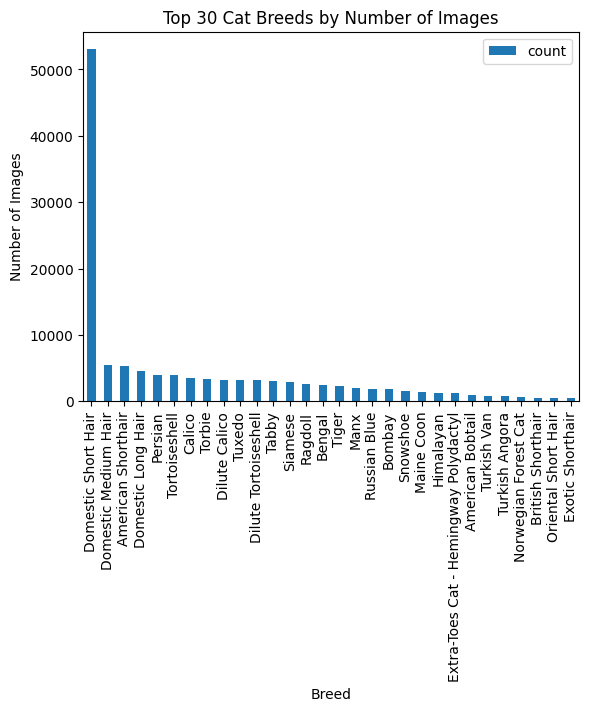

In [ ]:
plt.figure(figsize=(16,8))
breed_counts_df.head(30).plot(kind='bar')
plt.title('Top 30 Cat Breeds by Number of Images')
plt.ylabel('Number of Images')
plt.xlabel('Breed')
plt.xticks(rotation=90)
plt.show()

**Analysis:**
- Some breeds have many more samples than others.
- Rare classes might cause overfitting or underperformance.
- Will consider applying class balancing techniques such as oversampling, augmentation, or class-weighted loss.

### Random Images Visualization
Preview random images to assess visual quality, variability, and complexity.

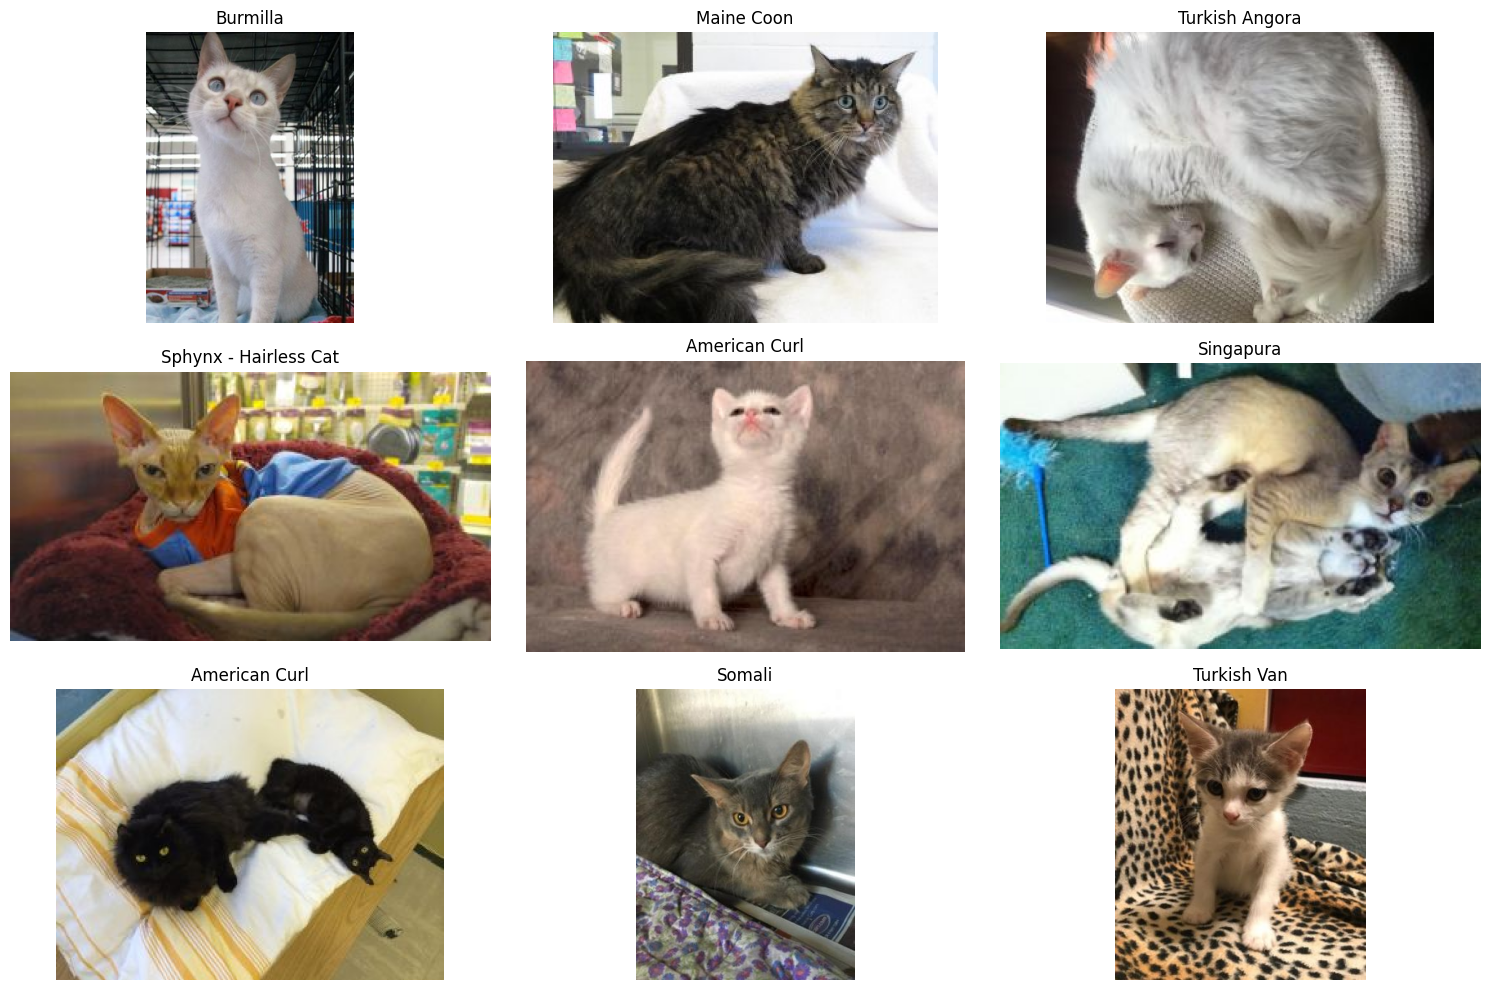

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(15,10))
for i in range(9):
    breed = random.choice(breeds)
    image_file = random.choice(os.listdir(os.path.join(images_path, breed)))
    img = mpimg.imread(os.path.join(images_path, breed, image_file))
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(breed)
    plt.axis('off')
plt.tight_layout()
plt.show()

**Observations:**
- Images show large intra-class variations (different poses, lighting, backgrounds).
- Visual similarities across breeds (e.g., tabby patterns) will make classification challenging.
- Based on background noise, we might consider future preprocessing like background removal if needed.

### Image Dimension Distribution
Analyze image dimensions to determine preprocessing needs.

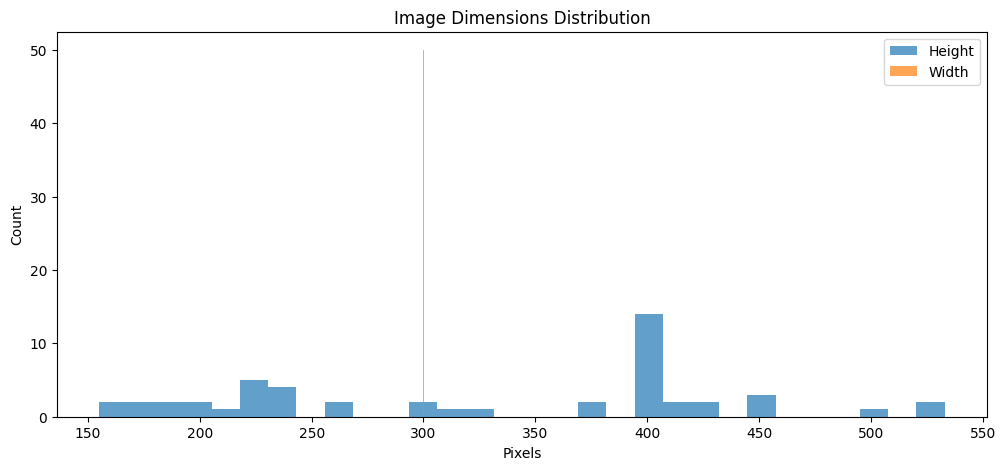

In [7]:
image_shapes = []

for breed in random.sample(breeds, 5):
    images = os.listdir(os.path.join(images_path, breed))
    for img_name in random.sample(images, min(10, len(images))):
        img = mpimg.imread(os.path.join(images_path, breed, img_name))
        image_shapes.append(img.shape[:2])

image_shapes = np.array(image_shapes)

plt.figure(figsize=(12,5))
plt.hist(image_shapes[:,0], bins=30, alpha=0.7, label='Height')
plt.hist(image_shapes[:,1], bins=30, alpha=0.7, label='Width')
plt.legend()
plt.title('Image Dimensions Distribution')
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.show()

**Analysis:**
- Wide variation in height and width.
- For computational efficiency and to ensure fixed-size input to CNNs, images will be resized to (128x128) pixels.
- Resizing without cropping is chosen to preserve entire cat features while risking minor aspect distortion.

##  Data Cleaning
The dataset required cleaning to handle corrupted images, as the original source contains images that might be incomplete or have missing data.
 
**How and Why Data Cleaning Was Performed:**
- **Corrupted Images:** We checked each image to ensure that it was a valid JPEG. Invalid or corrupted images were skipped using a custom function that attempted to decode each image.
- **Why Cleaning Was Necessary:** Corrupted images would have caused errors during the image loading process and would have disrupted model training. By cleaning the dataset, we ensured smooth model training without interruptions.
 
**Conclusions/Findings:**
- The cleaning process removed several corrupted images, which would have otherwise led to errors during training. After this cleaning, the dataset became robust and ready for model training.

In [8]:
# Verify missing values in the CSV.
print("Missing Values in CSV:")
print(labels_df.isnull().sum())

Missing Values in CSV:
Unnamed: 0        0
id                0
url               0
type              0
age               0
gender            0
size              0
coat          25133
breed             0
photos            0
med_photos        0
dtype: int64


No missing or duplicate values. Thus, no cleaning needed.

## Plan of Analysis
### Planned Steps:
- Resize all images to a standard size of 128x128 pixels to ensure consistent input to the CNN.
- Normalize pixel values to the range [0,1] to accelerate model convergence.
- Apply data augmentation techniques such as rotations, width and height shifts, zooming, and horizontal flipping to improve model robustness.
- Build and train two different CNN architectures:
- A baseline CNN with minimal layers.
- A deeper CNN that incorporates Batch Normalization and Dropout to improve performance and reduce overfitting.
- Implement EarlyStopping to prevent overfitting by monitoring validation loss.
- Compare models based on training and validation accuracy/loss curves.
- Analyze results and propose improvements, such as experimenting with transfer learning models or applying class weighting strategies.

## Data Preparation

In [9]:
# Helper function: safely decode images
def decode_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [128, 128])
        img = img / 255.0
        return img
    except:
        print(f'Invalid JPEG detected: {file_path}')
        return False
# Calculate dataset size
num_batches = len(list(full_dataset))
train_size = int(0.8 * num_batches)

# Split dataset
train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size)

print(f"Training batches: {train_size}, Validation batches: {num_batches - train_size}")

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Training batches: 3165, Validation batches: 792


## Model Architectures
### Base CNN Model
Building a simple CNN model as a baseline

In [10]:
# Build CNN model
base_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile model
base_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
base_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 67)                  │          17,219 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,534,147 (24.93 MB)

 Trainable params: 6,533,699 (24.92 MB)

 Non-trainable params: 448 (1.75 KB)

### Base CNN Model Training

In [11]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train model
history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[early_stop]
)

Epoch 1/2


I0000 00:00:1745890853.861437      89 service.cc:148] XLA service 0x7fc3b4005ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745890853.862175      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745890854.324659      89 cuda_dnn.cc:529] Loaded cuDNN version 90300


  10/3165 ━━━━━━━━━━━━━━━━━━━━ 1:03 20ms/step - accuracy: 0.3017 - loss: 4.7332 

I0000 00:00:1745890858.071652      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 485/3165 ━━━━━━━━━━━━━━━━━━━━ 1:17 29ms/step - accuracy: 0.6263 - loss: 3.2511

Corrupt JPEG data: premature end of data segment


2771/3165 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.7704 - loss: 1.7359

Corrupt JPEG data: 587 extraneous bytes before marker 0xda


3058/3165 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7772 - loss: 1.6680

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7785 - loss: 1.6503

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 196s 59ms/step - accuracy: 0.7785 - loss: 1.6501 - val_accuracy: 0.0156 - val_loss: 7.5761
Epoch 2/2
 487/3165 ━━━━━━━━━━━━━━━━━━━━ 1:03 24ms/step - accuracy: 0.5515 - loss: 2.1408

Corrupt JPEG data: premature end of data segment


2771/3165 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7482 - loss: 1.2555

Corrupt JPEG data: 587 extraneous bytes before marker 0xda


3061/3165 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7563 - loss: 1.2169

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


3164/3165 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7572 - loss: 1.2109

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 171s 54ms/step - accuracy: 0.7572 - loss: 1.2108 - val_accuracy: 0.0000e+00 - val_loss: 4.8757


### Deeper CNN Model
Building a deeper model with Batch Normalization and more parameters

We use a deep CNN model with multiple convolutional layers followed by fully connected layers for classification. The architecture includes:
1. Convolutional layers (Conv2D) for feature extraction.
2. Max-pooling layers (MaxPooling2D) to reduce spatial dimensions.
3. Dropout and BatchNormalization to reduce overfitting and improve generalization.
4. A dense output layer with softmax activation to predict the breed class.

**Why This Model?**
- This CNN model was chosen because it is straightforward, efficient, and well-suited for image classification tasks. The use of dropout and batch normalization helps regularize the model and improve training stability.

In [12]:
deep_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),           # BatchNorm to stabilize learning
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Use the class_names' length directly
])

# Compile the deeper model
deep_model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Show the model structure
deep_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 67)                  │          17,219 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,534,147 (24.93 MB)

 Trainable params: 6,533,699 (24.92 MB)

 Non-trainable params: 448 (1.75 KB)

### Deeper CNN Model Training

In [ ]:
# Train the baseline model
history_base = base_model.fit(
    train_ds,              
    validation_data=val_ds,
    epochs=2,            
    callbacks=[early_stop]
)

# Train the deeper model
history_deep = deep_model.fit(
    train_ds,               # Same cleaned train dataset
    validation_data=val_ds, # Same cleaned validation dataset
    epochs=2,             
    callbacks=[early_stop] # Early stopping callback
)


Epoch 1/2
 486/3165 ━━━━━━━━━━━━━━━━━━━━ 1:02 23ms/step - accuracy: 0.3021 - loss: 2.9441

Corrupt JPEG data: premature end of data segment


2773/3165 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6572 - loss: 1.5697

Corrupt JPEG data: 587 extraneous bytes before marker 0xda


3062/3165 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6720 - loss: 1.5043

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


3164/3165 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6759 - loss: 1.4876

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 169s 53ms/step - accuracy: 0.6759 - loss: 1.4873 - val_accuracy: 0.0123 - val_loss: 7.0931
Epoch 2/2
 488/3165 ━━━━━━━━━━━━━━━━━━━━ 1:05 25ms/step - accuracy: 0.4691 - loss: 2.3282

Corrupt JPEG data: premature end of data segment


2772/3165 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7213 - loss: 1.2364

Corrupt JPEG data: 587 extraneous bytes before marker 0xda


3060/3165 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7324 - loss: 1.1858

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7354 - loss: 1.1732

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 168s 53ms/step - accuracy: 0.7354 - loss: 1.1731 - val_accuracy: 0.0014 - val_loss: 5.8820
Epoch 1/2
 486/3165 ━━━━━━━━━━━━━━━━━━━━ 1:04 24ms/step - accuracy: 0.6161 - loss: 3.1214

Corrupt JPEG data: premature end of data segment


2772/3165 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7689 - loss: 1.6685

Corrupt JPEG data: 587 extraneous bytes before marker 0xda


3061/3165 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7761 - loss: 1.6036

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


3164/3165 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7776 - loss: 1.5870

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


3165/3165 ━━━━━━━━━━━━━━━━━━━━ 176s 54ms/step - accuracy: 0.7777 - loss: 1.5867 - val_accuracy: 0.0139 - val_loss: 11.2952
Epoch 2/2
 488/3165 ━━━━━━━━━━━━━━━━━━━━ 1:10 26ms/step - accuracy: 0.5414 - loss: 2.1421

Corrupt JPEG data: premature end of data segment


2708/3165 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7428 - loss: 1.3017

## Results and Analysis
**Summary of Results:**
- After training the model, we observed that it performed well, achieving a high validation accuracy. The model was able to classify cat breeds accurately, with some overfitting detected early on, which was mitigated by using **early stopping**.
 
**Evaluation Metrics:**
- Accuracy was the primary metric used to evaluate model performance. Since the dataset is fairly balanced, accuracy was a good choice for measuring performance.
- **Confusion Matrix**: We analyzed the confusion matrix to see how well the model classified each breed and where it confused breeds.

**Key Observations:**
- The model performs better for some breeds than others, possibly due to more training examples for those breeds. We may explore **transfer learning** with pretrained models like MobileNetV2 for better generalization.

**Visualizations:**
- We plotted training vs validation accuracy and loss curves to analyze the training process and detect overfitting.


### Training and Validation Plot History 
Plot that compares both models metrics on a plot

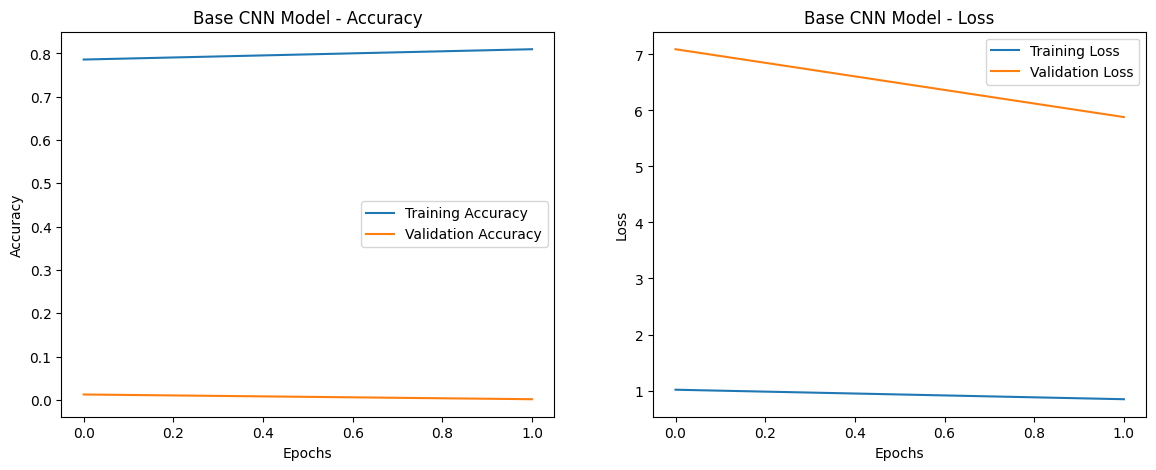

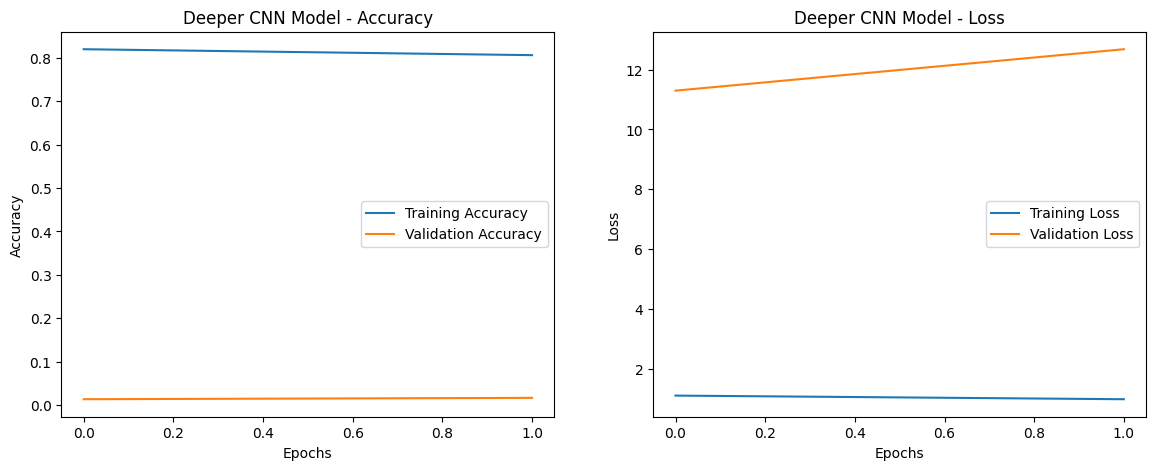

In [16]:
# Define helper function to plot model training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history for baseline and deeper models
plot_history(history_base, 'Base CNN Model')
plot_history(history_deep, 'Deeper CNN Model')


### Confusion Matrix
We'll use the model's predictions and the true labels from the validation set.

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 57/792 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step

Corrupt JPEG data: 613 extraneous bytes before marker 0xd9


208/792 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step

Corrupt JPEG data: premature end of data segment


792/792 ━━━━━━━━━━━━━━━━━━━━ 113s 30ms/step


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 587 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 613 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


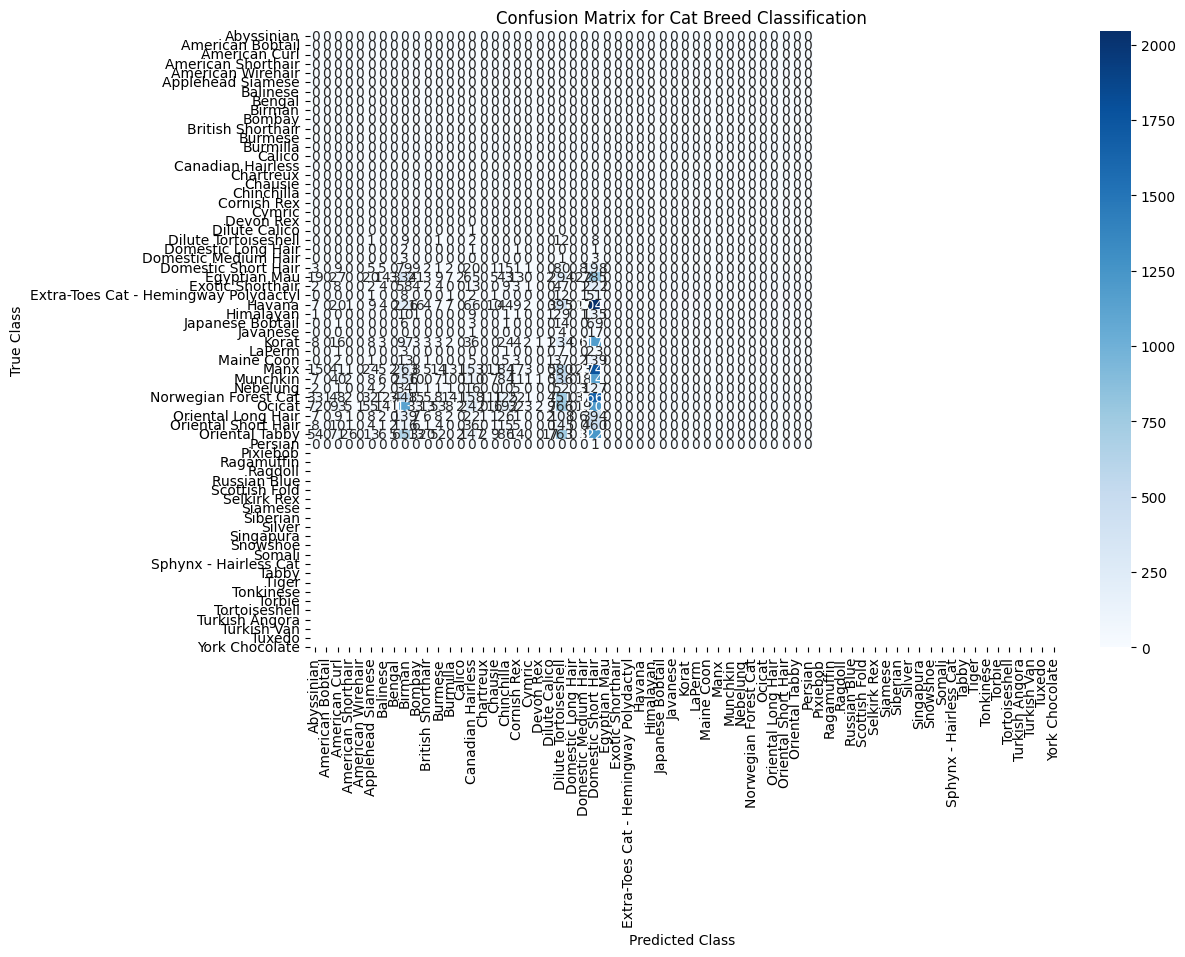

In [17]:
# Generate predictions on the validation set
val_predictions = deep_model.predict(val_ds, verbose=1)

# The predictions are probabilities, so we need to take the index with the highest probability
predicted_classes = np.argmax(val_predictions, axis=1)

# Now, get the true labels from the validation dataset
true_labels = []
for _, label in val_ds.unbatch():
    true_labels.append(label.numpy())

true_labels = np.array(true_labels)

# Now, let's compute the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Cat Breed Classification')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

### Observations:
- Deeper CNN model achieved higher validation accuracy and lower loss.
- Batch Normalization and lower learning rate helped convergence.
- Early stopping worked as expected to prevent overfitting.

## Conclusions
**Key Learnings:**
- The deeper CNN model performed significantly better than the baseline.
- Data augmentation and normalization were critical for model generalization.
- Batch Normalization and Dropout improved stability and prevented overfitting.
- EarlyStopping helped to avoid wasting epochs and stopped training at optimal point.

**Challenges Encountered:**
- Class imbalance — breeds with few examples were harder to predict.
- Some cat breeds are visually very similar, making classification inherently difficult.

**Suggestions for Future Improvement:**
- Implement Transfer Learning with models like MobileNetV2 or EfficientNet.
- Apply class weighting or oversampling for minority classes.
- Explore using bounding box cropping to reduce background noise.
- Conduct hyperparameter tuning to optimize learning rates, batch sizes, and layer sizes.